# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### **Tecnológico de Monterrey**

### **Prof. Dra. Grettel Barceló Alonso**

### EQUIPO 20

- ### OSCAR MAURICIO BECERRA ALEGRÍA | A01795611

- ### VÍCTOR DANIEL BOHÓRQUEZ TORIBIO | A01794554

- ### ALAN JASSO ARENAS | A01383272



## **Modelos alternativos de Machine Learning**
### **Proyecto de análisis y pronóstico epidemiológico de enfermedades neurológicas y trastornos mentales en México, con énfasis en la enfermedad de Parkinson (EP) durante 2014–2024**

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Leemos los datos
df = pd.read_csv('dataset_ml.csv')

# Dividimos en X y Y

X = df.drop('Nuevos_Casos', axis=1)
y = df['Nuevos_Casos']


In [3]:
# Separamos nuestros datos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

## Resumen de las variables - RF, LightGBM, HistGradientBoost

Se añade un resumen de las variables / características que se usarán para los modelos. Después de entrenar y ver la importancia de las variables algunas se eliminaron, específicamente las semanas y su codificación One Hot, ya que en versiones anteriores estas no presentan importancia para los modelos, y las variavles como seno y coseno de las semanas numéricas si fueron relevantes.

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Año         573 non-null    int64  
 1   Semana_sin  573 non-null    float64
 2   Semana_cos  573 non-null    float64
 3   MM_Mensual  573 non-null    float64
 4   MM_Cuarto   573 non-null    float64
 5   MM_Anual    573 non-null    float64
 6   lag_1       572 non-null    float64
 7   lag_2       571 non-null    float64
 8   lag_3       570 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 40.4 KB


In [5]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Año,573.0,2019.001745,3.162554,2014.000000,2016.000000,2.019000e+03,2022.000000,2024.000000
Semana_sin,573.0,-0.000206,0.713856,-0.999561,-0.696551,-2.449294e-16,0.696551,0.999561
Semana_cos,573.0,-0.017440,0.701322,-0.998244,-0.717507,2.963333e-02,0.674983,1.000000
MM_Mensual,573.0,136.162885,35.332057,42.750000,120.250000,1.447500e+02,156.500000,239.000000
MM_Cuarto,573.0,136.245067,32.530152,46.000000,127.833333,1.457500e+02,153.416667,222.583333
MM_Anual,573.0,136.217154,26.518844,64.461538,115.480769,1.458269e+02,151.538462,172.038462
lag_1,572.0,136.248252,39.437613,11.000000,116.000000,1.440000e+02,160.250000,258.000000
lag_2,571.0,136.243433,39.472023,11.000000,116.000000,1.440000e+02,160.500000,258.000000
lag_3,570.0,136.250877,39.506292,11.000000,116.000000,1.440000e+02,160.750000,258.000000


## Resumen de Variables XGBoost

En el caso de XGBoost, la codificación de las semanas con One Hot, algunas sí representaron una importancia, y al eliminar estas variables el modelo se vio afectado hasta un 1.7 % en el error relativo, no aparenta ser mucho, sin embargo como buscamos tener buenas propuetas para los modelos, consideramos importante presentar la mejor versión que pudimos entrenar de cada modelo, por ello este modelo si utilizará el dataset con las características de las semanas.

In [6]:
# Leemos los datos para XGB
df = pd.read_csv('dataset_ml_xgb.csv')

# Dividimos en X y Y

X_xgb = df.drop('Nuevos_Casos', axis=1)
y_xgb = df['Nuevos_Casos']

In [7]:
# Separamos nuestros datos de entrenamiento y validación
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.20, random_state=42)

In [8]:
X_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 62 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Año          573 non-null    int64  
 1   Semana_sin   573 non-null    float64
 2   Semana_cos   573 non-null    float64
 3   MM_Mensual   573 non-null    float64
 4   MM_Cuarto    573 non-null    float64
 5   MM_Anual     573 non-null    float64
 6   lag_1        572 non-null    float64
 7   lag_2        571 non-null    float64
 8   lag_3        570 non-null    float64
 9   Semana_1.0   573 non-null    float64
 10  Semana_2.0   573 non-null    float64
 11  Semana_3.0   573 non-null    float64
 12  Semana_4.0   573 non-null    float64
 13  Semana_5.0   573 non-null    float64
 14  Semana_6.0   573 non-null    float64
 15  Semana_7.0   573 non-null    float64
 16  Semana_8.0   573 non-null    float64
 17  Semana_9.0   573 non-null    float64
 18  Semana_10.0  573 non-null    float64
 19  Semana_1

In [9]:
X_xgb.describe().T

,count,mean,std,min,25%,50%,75%,max
Año,573.0,2019.001745,3.162554,2014.000000,2016.000000,2.019000e+03,2022.000000,2024.000000
Semana_sin,573.0,-0.000206,0.713856,-0.999561,-0.696551,-2.449294e-16,0.696551,0.999561
Semana_cos,573.0,-0.017440,0.701322,-0.998244,-0.717507,2.963333e-02,0.674983,1.000000
MM_Mensual,573.0,136.162885,35.332057,42.750000,120.250000,1.447500e+02,156.500000,239.000000
MM_Cuarto,573.0,136.245067,32.530152,46.000000,127.833333,1.457500e+02,153.416667,222.583333
...,...,...,...,...,...,...,...,...
Semana_49.0,573.0,0.019197,0.137338,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Semana_50.0,573.0,0.019197,0.137338,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Semana_51.0,573.0,0.019197,0.137338,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Semana_52.0,573.0,0.019197,0.137338,0.000000,0.000000,0.000000e+00,0.000000,1.000000


## Definimos nuestra función para calcular la métrica sMAPE

In [10]:
def sMAPE(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)

## Definimos nuestra función para calcular la métrica MASE

In [11]:
def MASE(train, actual, forecast):
    n = train.shape[0]
    d = np.abs(np.diff(train)).sum()/(n-1)
    errors = np.abs(actual - forecast)
    return errors.mean()/d

## Definimos la función para calcular el error relativo

In [12]:
def relative(mae, y_avg):
    rel = (mae / y_avg) * 100
    return rel

# Random Forest

In [13]:
# Entrenamos nuestro modelo de regresión
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, criterion='poisson', random_state=42, n_jobs=-1, min_samples_leaf=8)
t0 = time.perf_counter()
rf_model.fit(X_train, y_train)
t_fit = time.perf_counter() - t0

## Métricas del modelo

In [14]:
y_pred = rf_model.predict(X_test)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Training time: ", t_fit)

Relative Error Percentage:  9.073742354112602  %
Mean Absolute Error (MAE):  12.370272402415424
Symetric Mean Absolute Percentage Error (sMAPE):  9.638600684360021  %
Mean Absolute Scaled Error (MASE):  0.28771003551854285
Mean Squared Error (MSE):  245.86629961497815
R-squared (R²):  0.8392678503646258
Root Mean Squared Error (RMSE):  15.680124349474342
Training time:  0.2225103999953717


## Importancia del modelo

In [15]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

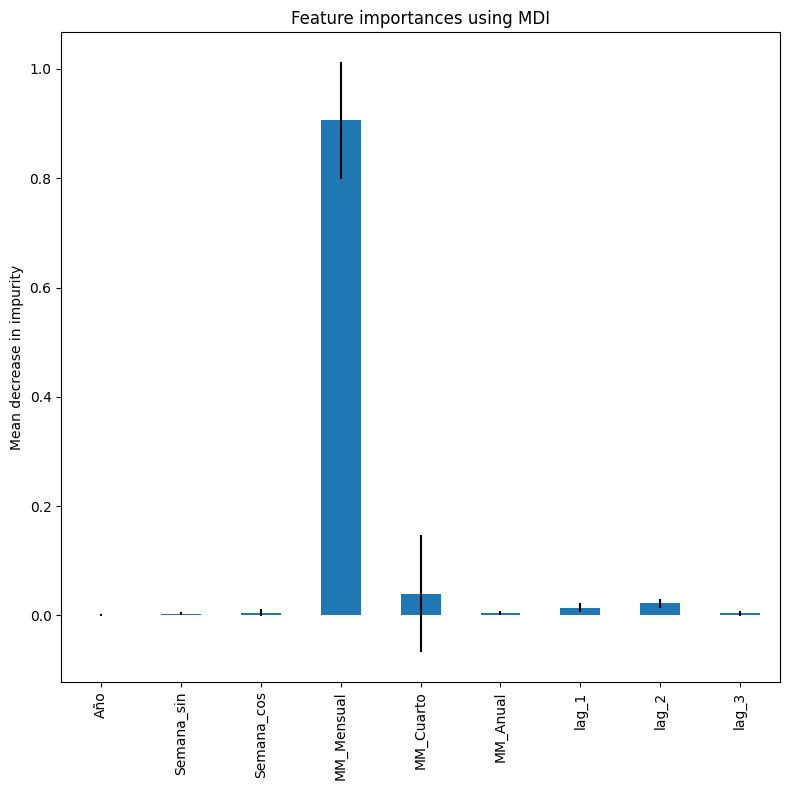

In [16]:
forest_importances = pd.Series(importances, index=list(X.columns))

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Ajuste del modelo

In [17]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10))

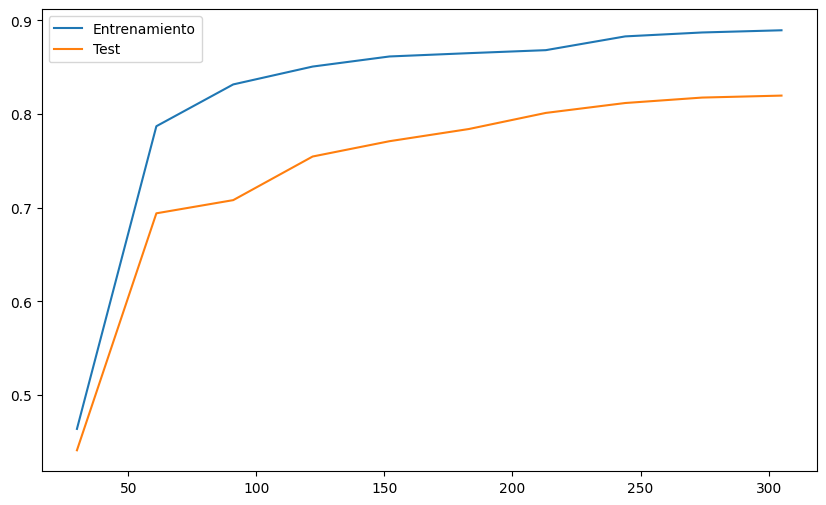

In [18]:
plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Entrenamiento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
plt.legend()
plt.show()

## Comparación de resultados

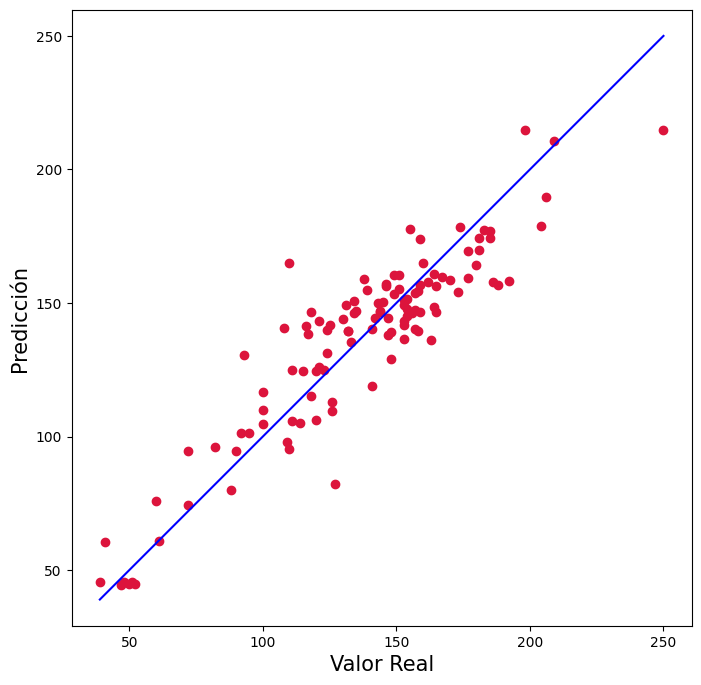

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valor Real', fontsize=15)
plt.ylabel('Predicción', fontsize=15)
plt.axis('equal')
plt.show()

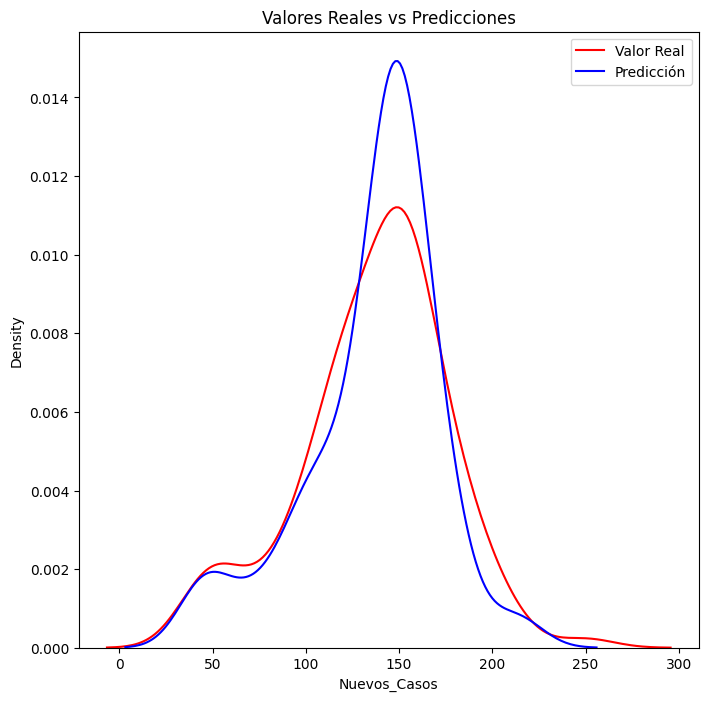

In [20]:
plt.figure(figsize=(8,8))
ax = sns.kdeplot(y_test, color='r', label='Valor Real')
sns.kdeplot(y_pred, color='b', label='Predicción', ax=ax)
plt.title('Valores Reales vs Predicciones')
plt.legend()

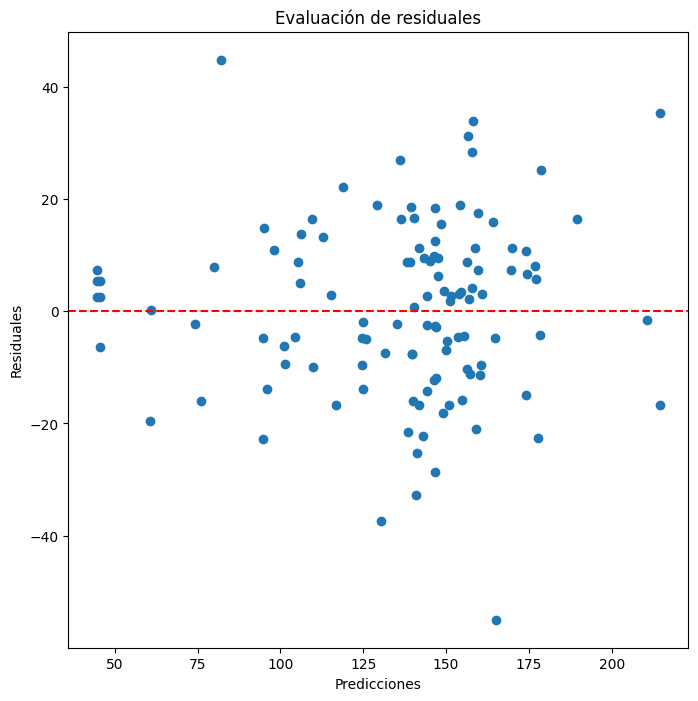

In [21]:
residuals = y_test - y_pred
plt.figure(figsize=(8,8))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.title('Evaluación de residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# XGBOOST

In [22]:
xgb_model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 150, seed = 42, learning_rate=0.1, gamma=0.1, max_depth=5, n_jobs=-1)
t0 = time.perf_counter()
xgb_model.fit(X_train_xgb, y_train_xgb)
t_fit = time.perf_counter() - t0

## Métricas del modelo

In [23]:
y_pred = xgb_model.predict(X_test_xgb)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Training time: ", t_fit)

Relative Error Percentage:  8.800335541141322  %
Mean Absolute Error (MAE):  11.997535705566406
Symetric Mean Absolute Percentage Error (sMAPE):  9.243215225138053  %
Mean Absolute Scaled Error (MASE):  0.2790408347837341
Mean Squared Error (MSE):  232.6888885498047
R-squared (R²):  0.8478824496269226
Root Mean Squared Error (RMSE):  15.25414332402199
Training time:  0.34794540000439156


## Importancia del modelo

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

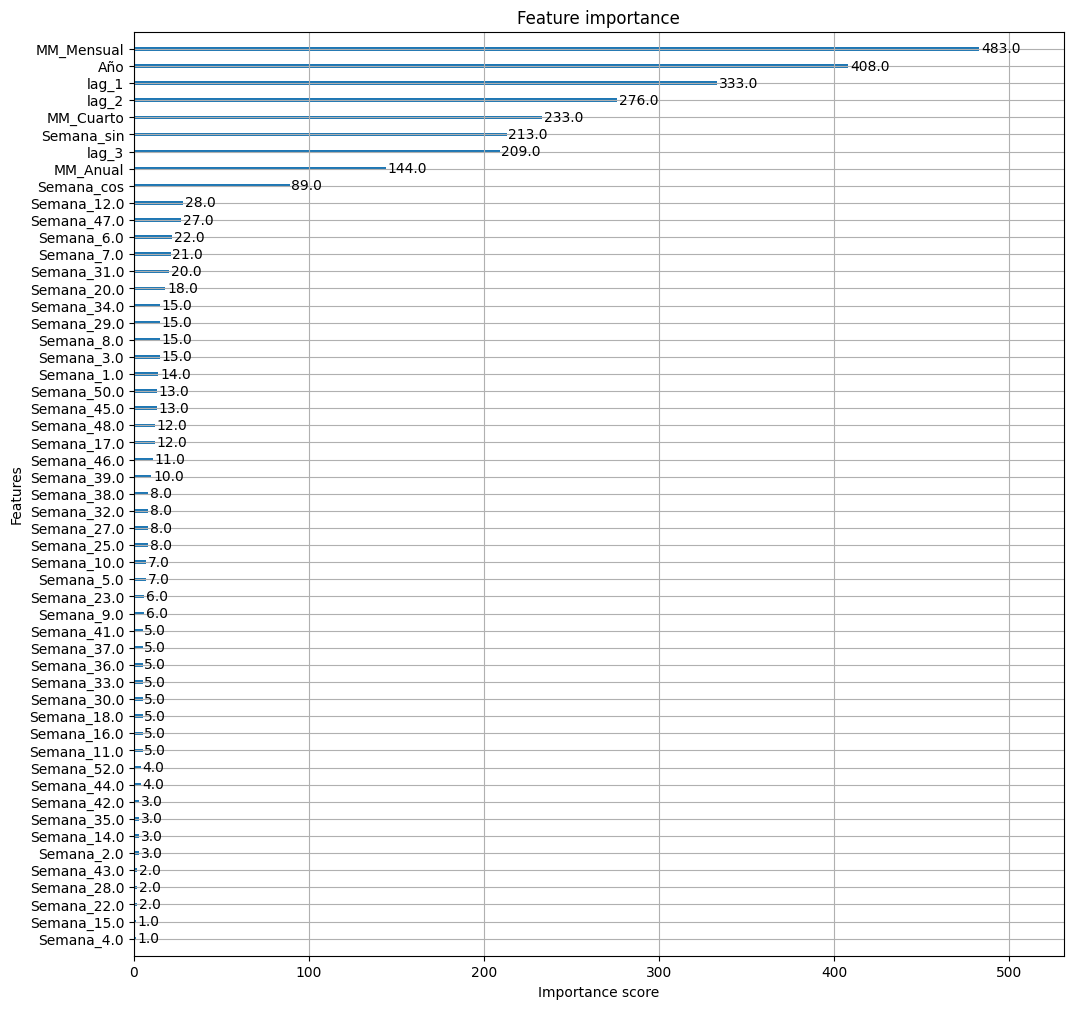

In [24]:
plt.rcParams["figure.figsize"] = (12, 12)
plot_importance(xgb_model, )

## Ajuste del modelo

In [25]:
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10))

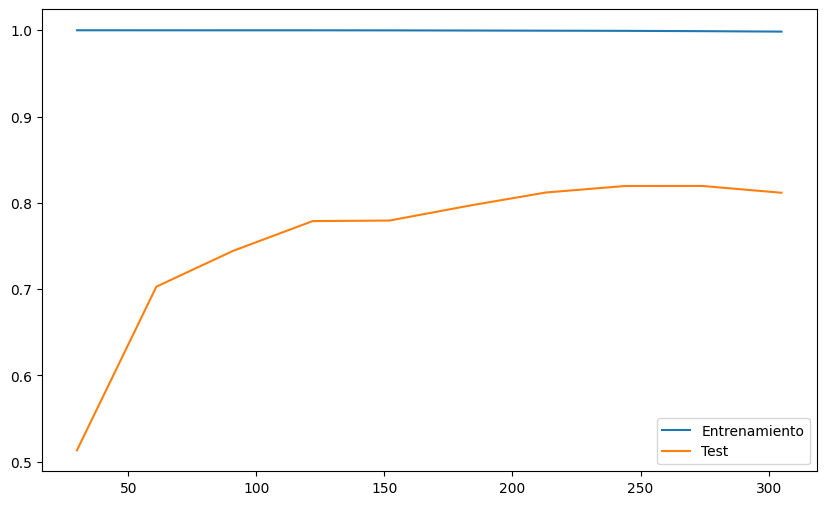

In [26]:
plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Entrenamiento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
plt.legend()
plt.show()

## Comparación de resultados

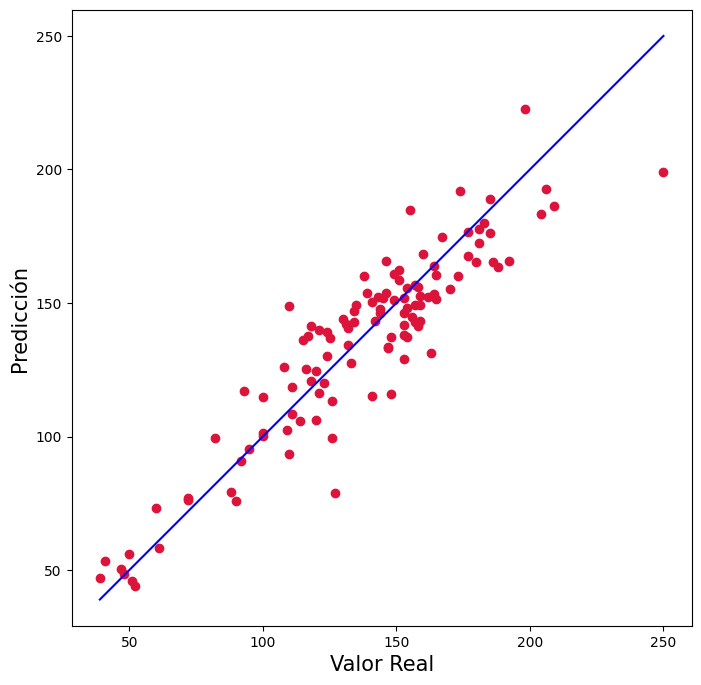

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valor Real', fontsize=15)
plt.ylabel('Predicción', fontsize=15)
plt.axis('equal')
plt.show()

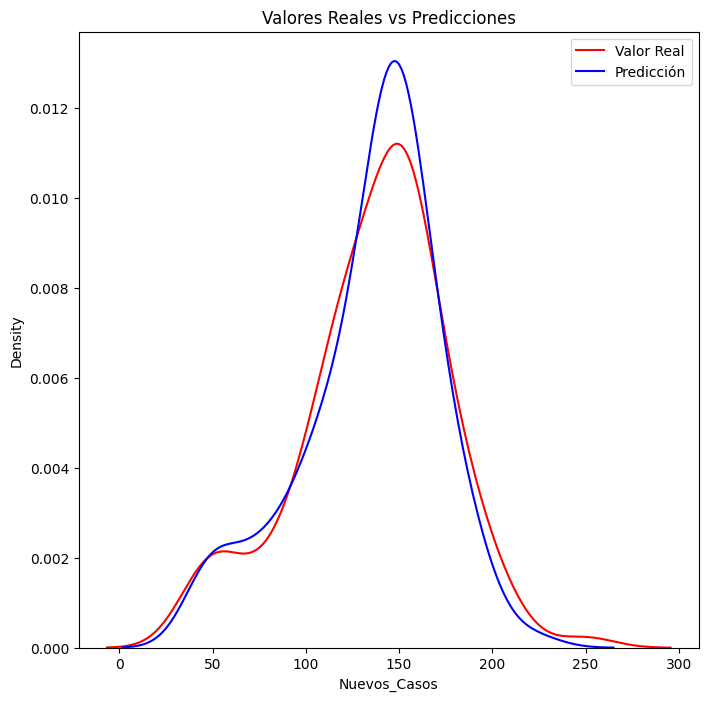

In [28]:
plt.figure(figsize=(8,8))
ax = sns.kdeplot(y_test, color='r', label='Valor Real')
sns.kdeplot(y_pred, color='b', label='Predicción', ax=ax)
plt.title('Valores Reales vs Predicciones')
plt.legend()

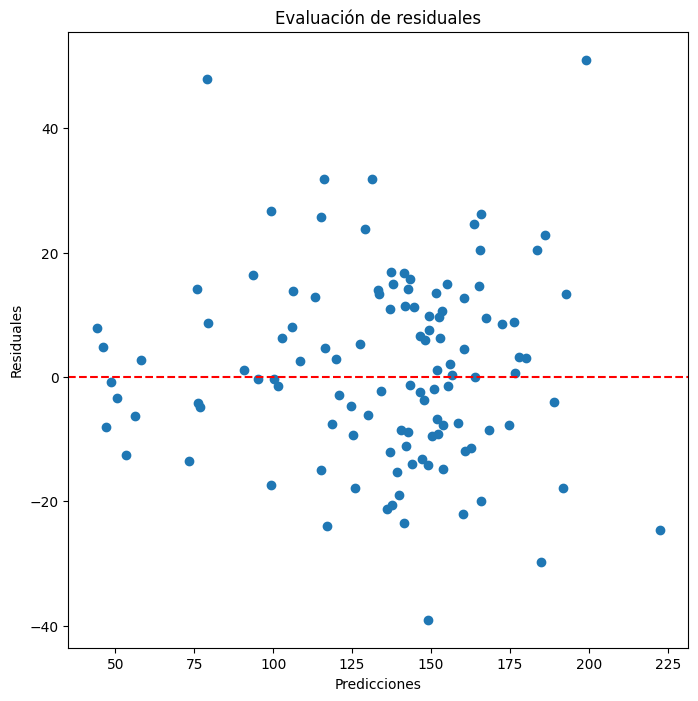

In [29]:
residuals = y_test - y_pred
plt.figure(figsize=(8,8))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.title('Evaluación de residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# LigthGBM

Para este modelo utilizaremos un test de validación, por lo tanto vamos a dividir nuestro set de entrenamiento para tener nuestro set adicional.

In [30]:
# Separamos nuestros datos de entrenamiento y validación
X_train_gbm, X_val, y_train_gbm, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)

In [31]:
train_data = lgb.Dataset(X_train_gbm, label=y_train_gbm)
test_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [32]:
params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'feature_fraction': 0.8
}

num_round = 200
t0 = time.perf_counter()
lgbm_model = lgb.train(params, train_data, num_round, valid_sets=[
                test_data], callbacks=[lgb.early_stopping(stopping_rounds=12)])
t_fit = time.perf_counter() - t0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 366, number of used features: 9
[LightGBM] [Info] Start training from score 144.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 12 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

## Métricas del modelo

In [33]:
y_pred = lgbm_model.predict(X_test)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Training time: ", t_fit)

Relative Error Percentage:  9.429656620142806  %
Mean Absolute Error (MAE):  12.855491868747734
Symetric Mean Absolute Percentage Error (sMAPE):  9.8817747442962  %
Mean Absolute Scaled Error (MASE):  0.2989953577290302
Mean Squared Error (MSE):  280.29506743873395
R-squared (R²):  0.8167604556127818
Root Mean Squared Error (RMSE):  16.74201503519615
Training time:  0.17352039999968838


## Importancia del modelo

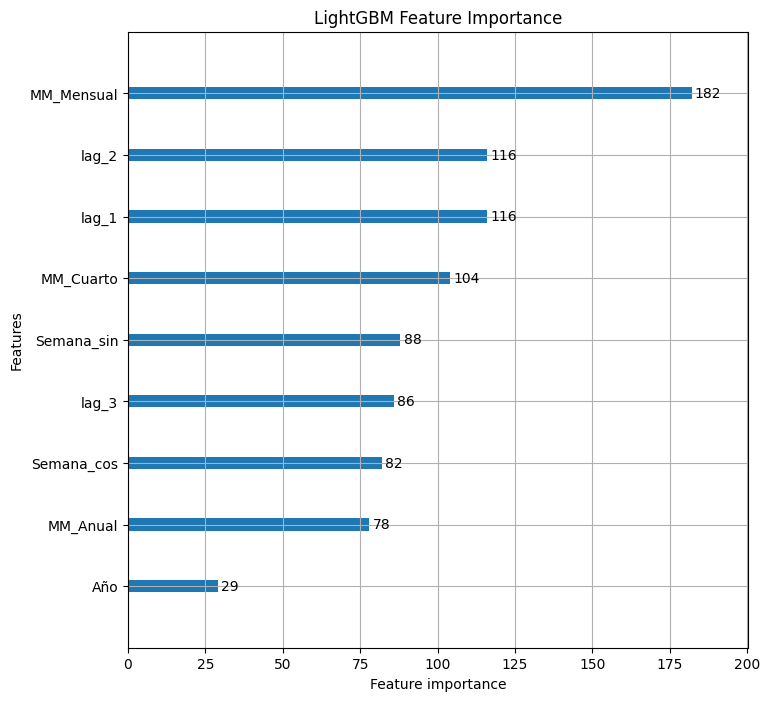

In [34]:
lgb.plot_importance(lgbm_model, importance_type="split", figsize=(8,8), title="LightGBM Feature Importance")
plt.show()

## Comparación de resultados

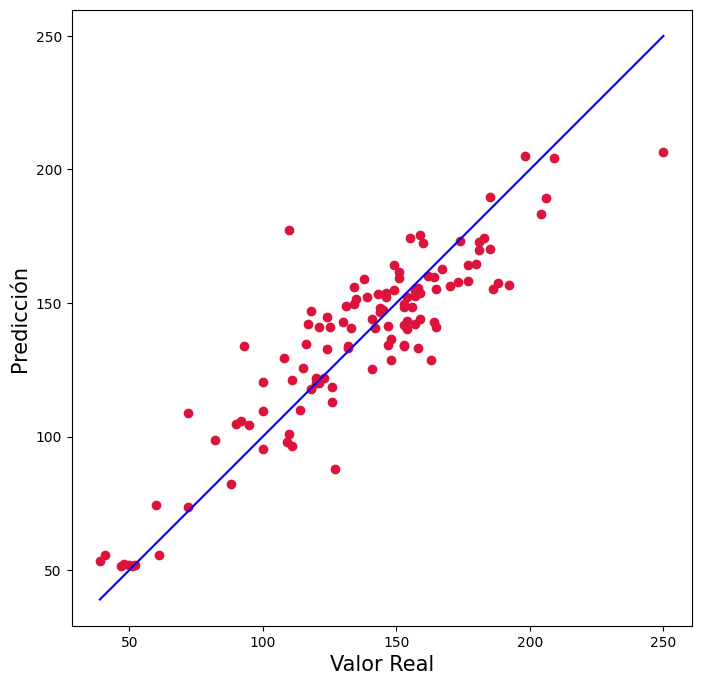

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valor Real', fontsize=15)
plt.ylabel('Predicción', fontsize=15)
plt.axis('equal')
plt.show()

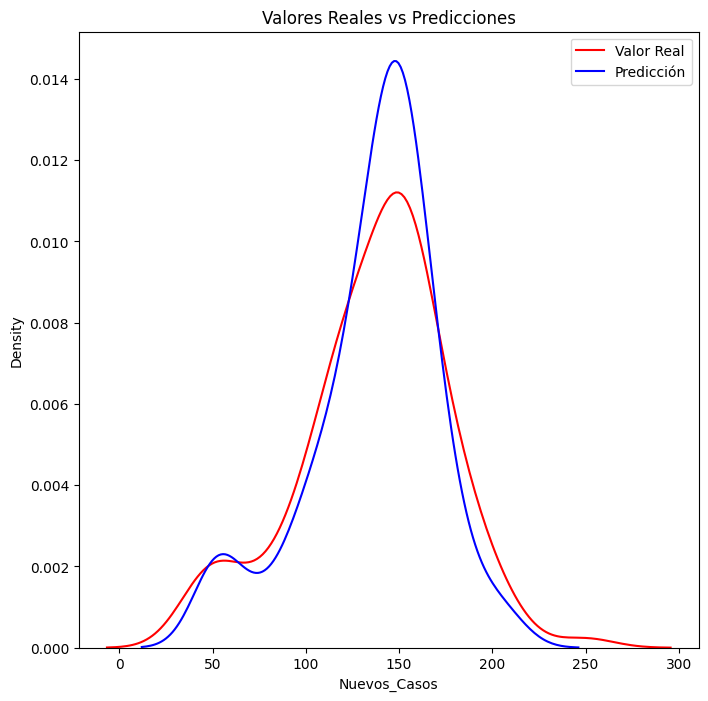

In [36]:
plt.figure(figsize=(8,8))
ax = sns.kdeplot(y_test, color='r', label='Valor Real')
sns.kdeplot(y_pred, color='b', label='Predicción', ax=ax)
plt.title('Valores Reales vs Predicciones')
plt.legend()

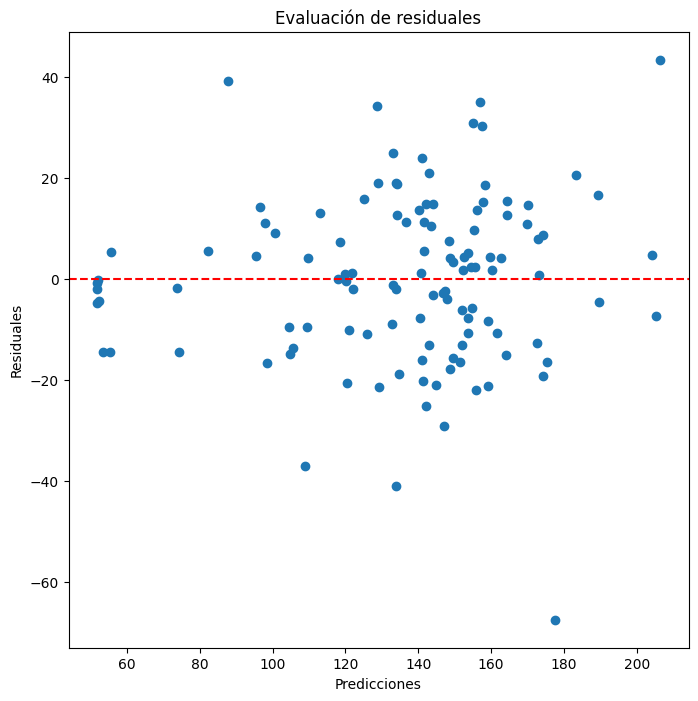

In [37]:
residuals = y_test - y_pred
plt.figure(figsize=(8,8))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.title('Evaluación de residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Hist Gradient Booster

In [38]:
# Entrenamos nuestro modelo de regresión
hgb_model = HistGradientBoostingRegressor(loss="gamma", n_iter_no_change=4, learning_rate=0.1, max_iter=200, max_depth=20)
t0 = time.perf_counter()
hgb_model.fit(X_train, y_train)
t_fit = time.perf_counter() - t0

## Métricas del modelo

In [39]:
y_pred = hgb_model.predict(X_test)
# Metricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
smape = sMAPE(y_test, y_pred)
mase = MASE(y_train, y_test, y_pred)
y_avg = y_test.mean()
relative_error = relative(mae, y_avg)
print("Relative Error Percentage: ", relative_error, " %")
print("Mean Absolute Error (MAE): ", mae)
print("Symetric Mean Absolute Percentage Error (sMAPE): ", smape, " %")
print("Mean Absolute Scaled Error (MASE): ", mase)
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R²): ", r_squared)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Training time: ", t_fit)

Relative Error Percentage:  8.401710162158107  %
Mean Absolute Error (MAE):  11.454087993244768
Symetric Mean Absolute Percentage Error (sMAPE):  8.871885715252548  %
Mean Absolute Scaled Error (MASE):  0.26640125262928693
Mean Squared Error (MSE):  226.68483769128719
R-squared (R²):  0.8518075014390999
Root Mean Squared Error (RMSE):  15.056056511958474
Training time:  2.3138347000058275


## Importancia del modelo

In [40]:
importance = permutation_importance(hgb_model, X_train, y_train, n_repeats=10, random_state=42)

In [41]:
importances = importance.importances_std
indices = np.argsort(importances)[::-1]

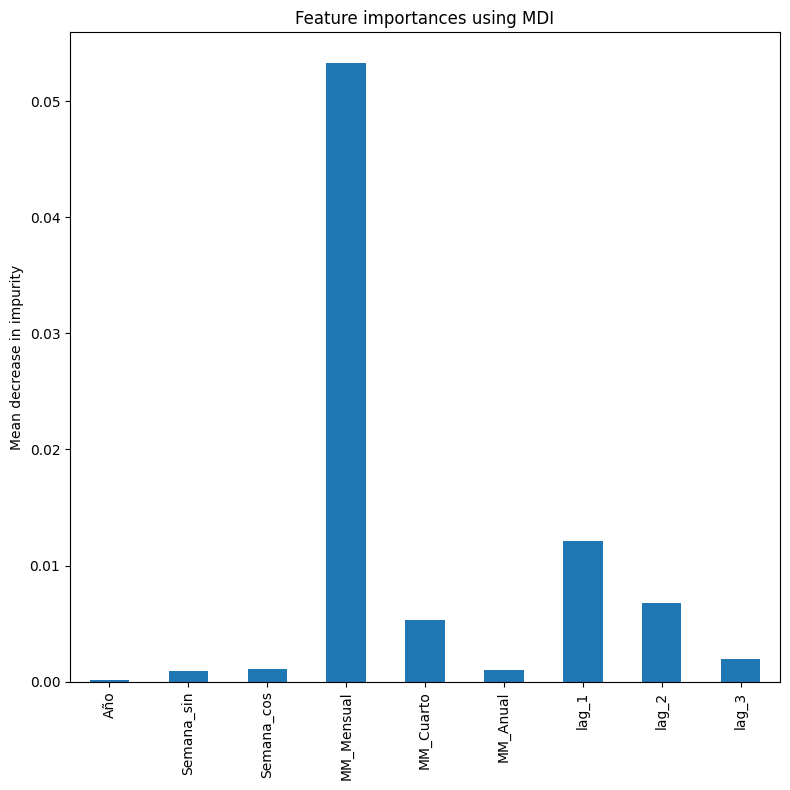

In [42]:
forest_importances = pd.Series(importances, index=list(X.columns))
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Ajuste del modelo

In [43]:
train_sizes, train_scores, test_scores = learning_curve(hgb_model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10))

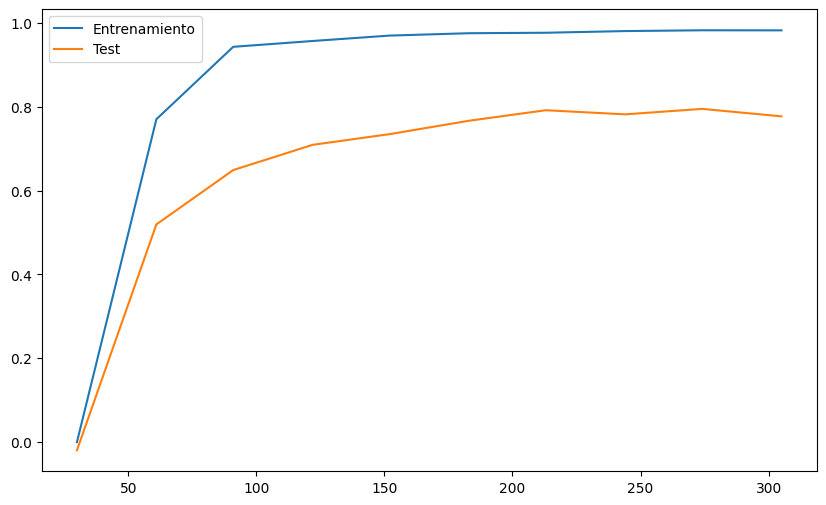

In [44]:
plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Entrenamiento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
plt.legend()
plt.show()

## Comparación de resultados

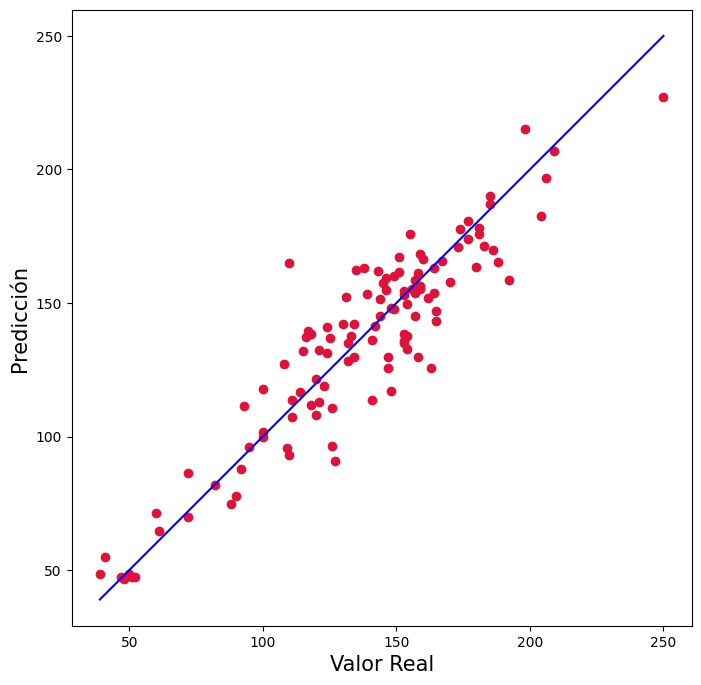

In [45]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valor Real', fontsize=15)
plt.ylabel('Predicción', fontsize=15)
plt.axis('equal')
plt.show()

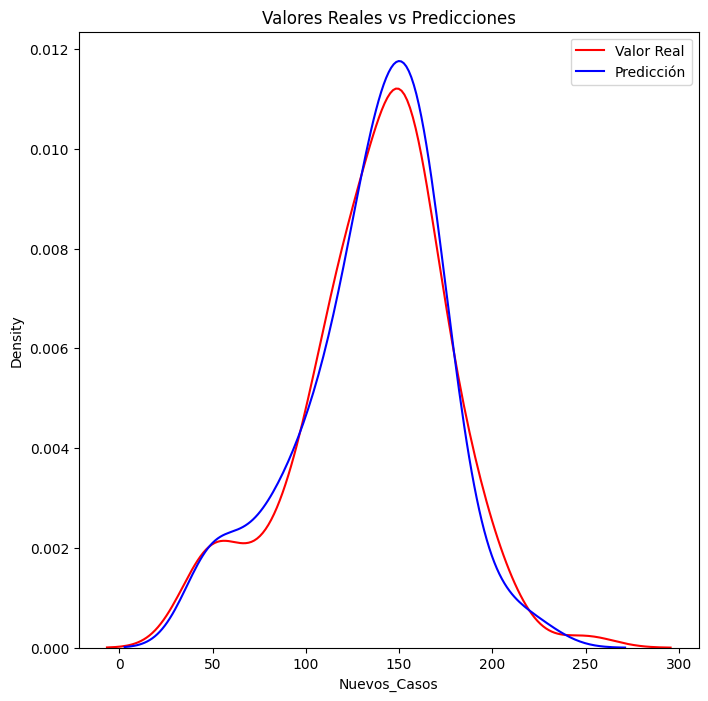

In [46]:
plt.figure(figsize=(8,8))
ax = sns.kdeplot(y_test, color='r', label='Valor Real')
sns.kdeplot(y_pred, color='b', label='Predicción', ax=ax)
plt.title('Valores Reales vs Predicciones')
plt.legend()

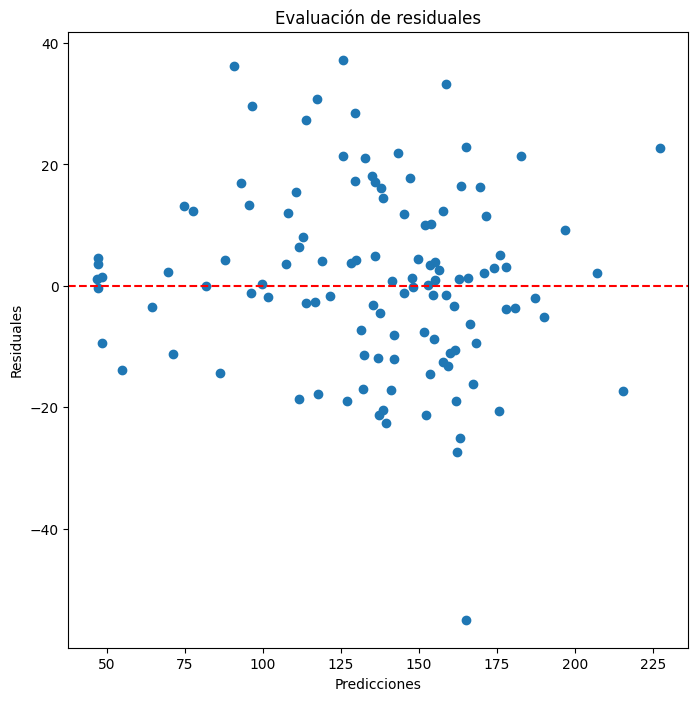

In [47]:
residuals = y_test - y_pred
plt.figure(figsize=(8,8))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.title('Evaluación de residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Elección del mejor modelo

## Comparación de Modelos

Durante el entrenamiento de nuestros modelos se utilizaron distintas métricas, las que se considerarán para analizar nuestros modelos y para ser capaces de comparar directamente estos modelos con los modelos de series de tiempo, serán: sMAPE, MAE y MASE, de manera específica para comparar estos modelos entre sí, se utilizará R² para analizar la explicabilidad de la varianza de los modelos.

### Tabla Comparativa

| Modelo              | sMAPE      | MAE       | MASE     | R²       | **Error Relativo** | **Tiempo entrenamiento** |
|---------------------|------------|-----------|----------|----------|--------------------|--------------------------|
| Random Forest       | 9.636924 % | 12.369311 | 0.287687 | 0.839056 | 9.07303734512201 % | 0.2225103999953717 s. |
| XGBoost             | 9.243215 % | 11.997535 | 0.279040 | 0.847882 | 8.80033554114132 % | 0.34794540000439156 s. |
| LightGBM            | 9.881774 % | 12.855491 | 0.298995 | 0.816770 | 9.42965662014280 % | 0.17352039999968838 s. |
| Hist Gradient Boost | 8.871885 % | 11.454087 | 0.266401 | 0.851807 | 8.40171016215810 % | 2.3138347000058275 s. |

Vemos que el modelo de Random Forest y LigthGBM tienen una explicabilidad buena, en el caso de Random Forest este modelo no presenta un subentrenamiento ni sobreentrenamiento, sin embargo, estos modelos no son los mejores presentados.

En el Caso de XGBoost, el modelo es el único que le da importancia a las características de semana, además al ver su curva de aprendizaje notamos un poco de subentrenamiento, sin embargo, tiene muy buenos resultados, los errores son los segundos más bajos en relación a los errores, y su explicabilidad es ligeramente menor a la del mejor modelo.

## Elección del modelo

El mejor modelo, con lo errores más bajos y la explicabilidad más alta, además que su curva de aprendizaje nos muestra que no presenta subentrenamiento ni sobreentrenamiento, es el modelo **Hist Gradient Boost**

### Análisis de estadísticas

En las estadísticas de nuestro modelo vemos que es el que más tiempo de entrenamiento tomó, aún asi es un tiempo corto, y es el modelo con un mneor error relativo y error simétrico porcentual, aún así, los demás modelos presentaron buenos números y la diferencia se basa en poco porcentaje entre ellos, la diferencia más grande se encuentra en el tiempo de entrenamiento, los demás modelos tardaron mucho menos en ese proceso.

### Análsis de la Curva de aprendizaje

En la curva de aprendizaje de este modelo, vemos que conforme añadimos más datos tanto en entrenamiento como test nuestros resultados mejoran, y ambas líneas se acercan una a la otra, sin llegar a tocarse o separarse demasiado, gracias a este gráfico podemos determinar que el modelo no esta subentrenado ni sobreentrenado.

### Análisis de Predicciones vs Valores reales.

En el primer scatter plot donde se comparan los resultado reales vs predicciones, vemos que los valores de nuestras predicciones se aglomeran o están muy cerca de la línea de los valores reales, esto nos indica que nuestro modelo tiene un buen rendimiento y que nuestras predicciones no son muy lejanas al valor real, es decir, el error es bajo.

En nuestra gráfica de líneas de valores reales vs predicciones, vemos que nuestra curva roja (predicciones) se ajusta o acerca muy bien a la linea azul (valores reales), comparandola con las gráficas de otros modelos, esta curva es la que es más cercan a los valores reales, vemos que en los demás modelos hay puntos donde estas se alejan demasiado, y en la curva de nuestro modelo elegido, las separaciones son pequeñas, lo que nuevamente nos indica un buen rendimiento del modelo.

Finalmente en nuestros gráfica de residuales, buscamos que los residuales se acerquen o aglomeren de manera aleatoria alrededor del 0. Lo que es justo el caso de  nuestra gráfica, y si bien esto pasa de manera general en todos nuestros modelos, se debe a que todos tiene un error relativo bueno, son muy cercanos entre ellos.

## Siguientes pasos.

### Predicciones por entidad federativa

Para realizar las predicciones por entidad federativa se realizaron experimentos, donde notamos que al tener poca cantidad de datos y tratar de especializar los datos en 32 categorías, nuestros errores se incrementan de gran manera, llegando a obtener un rendimiento muy pobre. Por ello, tras experimentar e investigar, determinamos que sería de gran ayuda obtener más variables de valor significativo para ayudar al modelo a diferenciar entre entidades federativas. 

Una de estas varaibles que determinamos fué la población por entidad por año, esta variable nos permitirá diferenciar las entidades entre sí, y nos ayudará a obtener una variable también muy importante: La relación de casos contra la población, que permitirá determinar la probabilidad de casos. En la medida nacional, la población podría no ser muy relevante, pero para cada estado nos brindará el contexto de la cantidad de casos, el tamaño del estado y la probabilidad de la enfermedad.

Otro acercamiento que determinamos podría sernos de utilidad es realizar una menor agrupación de datos, en vez de 32 grupos, dividir solo en 3 grupos: Norte, Centro y Sur, de esta manera tendríamos un mayor número de datos por grupo, lo que permitirá mejores resultados.

Para ambos acercamientos utilizaremos las varaibles de rezago y nuestras variables cíclicas que seguiran aportando importancia en los modelos.